Dataset link- https://www.kaggle.com/kazanova/sentiment140

## Importing Libraries

In [91]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords #stopwords
from nltk.stem import PorterStemmer ,WordNetLemmatizer #stemmer and lemmatizer
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
from nltk.tokenize import RegexpTokenizer #tokenizer
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam #optimizers for model
from tensorflow.keras.preprocessing.text import Tokenizer #tokenizer
from tensorflow.keras.preprocessing import sequence 
from tensorflow.keras.callbacks import ReduceLROnPlateau #callbacks

## Loading the data

In [92]:
data_df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin')
data_df.columns=["label", "time", "date", "query", "username", "text"]
data_df.head()# top 5 rows

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [93]:
# last 5 rows
data_df.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [94]:
# Get the number of rows and columns in the dataset
rows=data_df.shape[0]
columns=data_df.shape[1]
print('The number of rows in the dataset are ',rows)
print('The number of columns in the dataset are ',columns)

The number of rows in the dataset are  1599999
The number of columns in the dataset are  6


**Columns/Features in dataset**

In [95]:
print('All the columns in the dataset are: ',data_df.columns)

All the columns in the dataset are:  Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')


### Basic Data Analysis

In [96]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


**Checking for null values**

In [97]:
data_df.isnull().sum().sort_values(ascending=False)

label       0
time        0
date        0
query       0
username    0
text        0
dtype: int64

Hence, there are no null values in the dataset

**Getting count of target variable**

In [98]:
val_count=data_df['label'].value_counts()
val_count

4    800000
0    799999
Name: label, dtype: int64

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

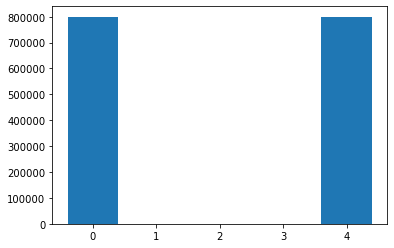

In [99]:
# Plotting the target variable counts
plt.bar(data_df['label'].value_counts().index,data_df['label'].value_counts())
plt.title

Hence, we have an equally distributed target column. no skewness

## Data Preparation

Since, tweets often consists of other user mentions, hyperlink texts, emoticons and punctuations,we cannot have these characters while training a model. So we have to clean the text data using various preprocessing and cleaning methods.

**Selecting the 'text' and 'label' columns**

In [100]:
data_df=data_df[['text','label']]
# Assigning 1 to Positive sentment 4
data_df['label'][data_df['label']==4]=1

**Separating the positive and negative tweets**

In [101]:
pos_df = data_df[data_df['label'] == 1]
neg_df = data_df[data_df['label'] == 0]

In [102]:
# Using a part of the dataframe for optimal speed of model
pos_df = pos_df.iloc[:int(25000)]
neg_df = neg_df.iloc[:int(25000)]
# Combining the positive and negative tweets
data_df=pd.concat([pos_df,neg_df])

**Converting text statements into lower case for uniformity**

In [103]:
data_df['text']=data_df['text'].str.lower()
data_df['text'].head()

799999         i love @health4uandpets u guys r the best!! 
800000    im meeting up with one of my besties tonight! ...
800001    @darealsunisakim thanks for the twitter add, s...
800002    being sick can be really cheap when it hurts t...
800003      @lovesbrooklyn2 he has that effect on everyone 
Name: text, dtype: object

**Removing the stopwords**

In [104]:
nltk.download("stopwords")
stopwords_list = stopwords.words('english')
print(stopwords_list) # This gives us a complete list of all the english stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]   Package stopwords is already up-to-date!


Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification.

#### Cleaning and removing the above stop words list from the tweet texts

In [105]:
STOPWORDS = set(stopwords_list)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data_df['text'] = data_df['text'].apply(lambda text: cleaning_stopwords(text))
data_df['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

**Cleaning and removing punctuations**

In [106]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    punctuation_cleaner = str.maketrans('', '', punctuations_list)
    return text.translate(punctuation_cleaner)
data_df['text']= data_df['text'].apply(lambda x: cleaning_punctuations(x))
data_df['text'].head()

799999                   love health4uandpets u guys r best
800000    im meeting one besties tonight cant wait  girl...
800001    darealsunisakim thanks twitter add sunisa got ...
800002    sick really cheap hurts much eat real food plu...
800003                       lovesbrooklyn2 effect everyone
Name: text, dtype: object

##### Since tweets often contain tags and emails, cleaning and removing emails from texts

In [107]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)
data_df['text']= data_df['text'].apply(lambda x: cleaning_email(x))
data_df['text'].head()

799999                   love health4uandpets u guys r best
800000    im meeting one besties tonight cant wait  girl...
800001    darealsunisakim thanks twitter add sunisa got ...
800002    sick really cheap hurts much eat real food plu...
800003                       lovesbrooklyn2 effect everyone
Name: text, dtype: object

**Cleaning and removing URLs**

In [108]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
data_df['text'] = data_df['text'].apply(lambda x: cleaning_URLs(x))
data_df['text'].head()

799999                   love health4uandpets u guys r best
800000    im meeting one besties tonight cant wait  girl...
800001    darealsunisakim thanks twitter add sunisa got ...
800002    sick really cheap hurts much eat real food plu...
800003                       lovesbrooklyn2 effect everyone
Name: text, dtype: object

**Cleaning and removing numericals**

In [109]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data_df['text'] = data_df['text'].apply(lambda x: cleaning_numbers(x))
data_df['text'].head()

799999                    love healthuandpets u guys r best
800000    im meeting one besties tonight cant wait  girl...
800001    darealsunisakim thanks twitter add sunisa got ...
800002    sick really cheap hurts much eat real food plu...
800003                        lovesbrooklyn effect everyone
Name: text, dtype: object

#### **Visualizing with word cloud**

Text(0.5, 1.0, 'Word Cloud for Positive Tweets')

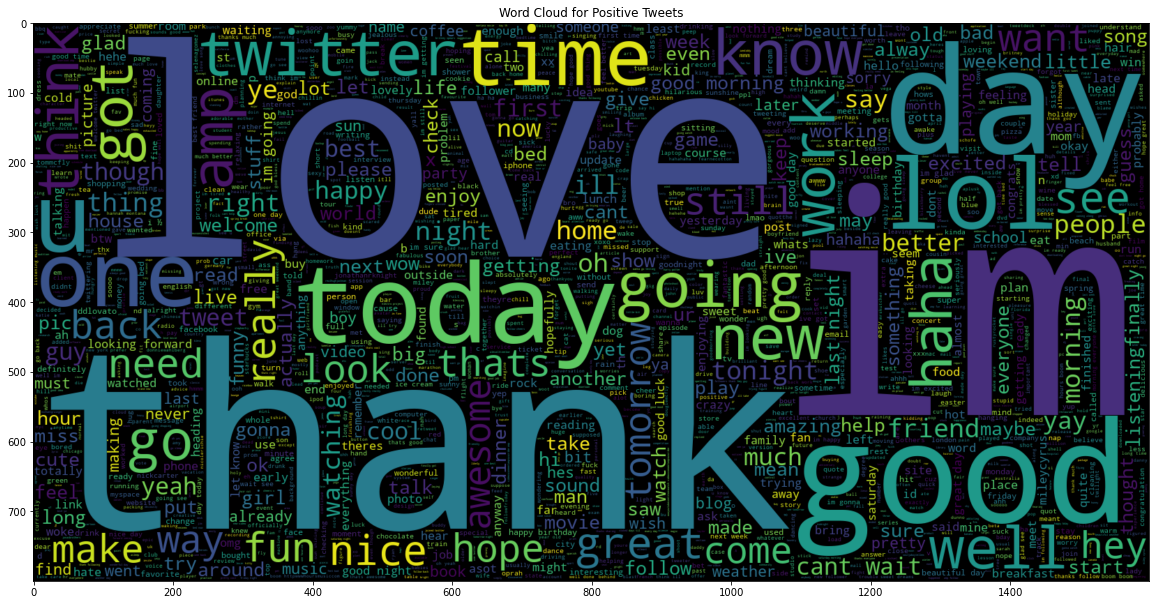

In [110]:
# Positive tweet words
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_df[data_df['label'] == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word Cloud for Positive Tweets')

Text(0.5, 1.0, 'Word Cloud for Negative Tweets')

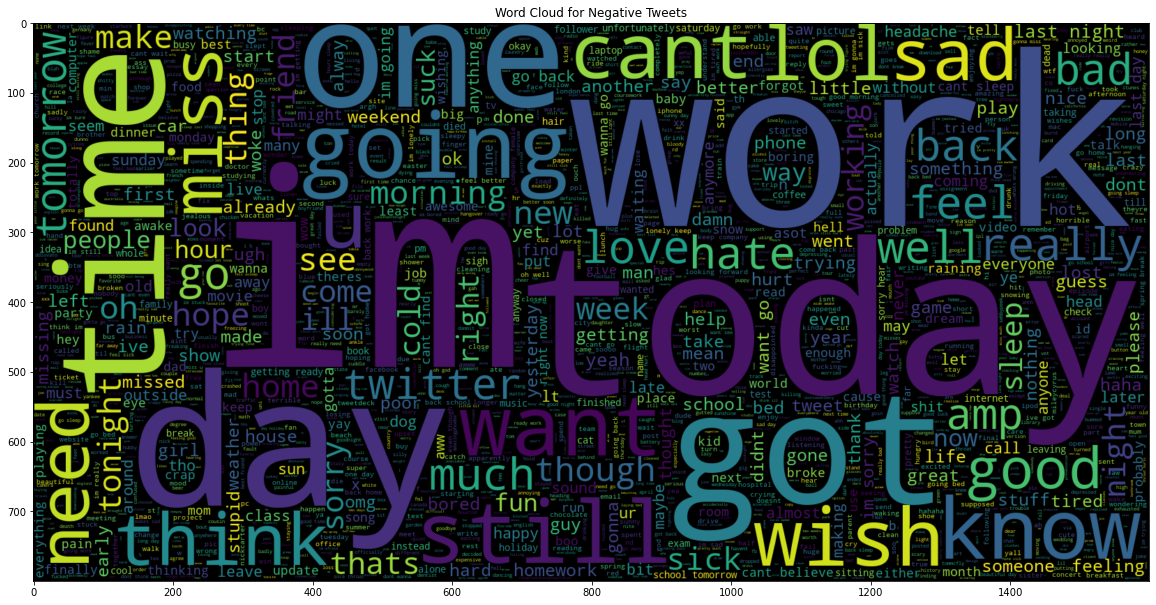

In [111]:
# Negative Tweet words
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_df[data_df['label'] == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word Cloud for Negative Tweets')

**Getting tokenization of tweet text**

Tokenizer create tokens for every word in the data corpus and map them to a index using dictionary.

In [112]:
tokenizer = RegexpTokenizer(r'\w+')
data_df['text'] = data_df['text'].apply(tokenizer.tokenize)
data_df['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

**Applying Stemming**

In [113]:
stemmer = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [stemmer.stem(word) for word in data]
    return data

data_df['text']= data_df['text'].apply(lambda x: stemming_on_text(x))
data_df['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

**Applying Lemmatizer**

In [ ]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
lemm = WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lemm.lemmatize(word) for word in data]
    return data

data_df['text'] = data_df['text'].apply(lambda x: lemmatizer_on_text(x))
data_df['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

## Splitting data into train and test sets

In [ ]:
# Separating feature and target variables
X=data_df['text']
y=data_df['label']

Now, we need to convert texts into different arrays. For this we will be using a maximum of 400 words, which will act as the features for the model. These 400 words will be selected on the importance that will distinguish between the positive tweets and negative tweets.

The next step to representing text in a way that can be meaningfully used by machine learning programs is to create numerical sequences that represent the sentences in the text.

Each sentence will be converted into a sequence where each word is replaced by its number in the word index

In [ ]:
max_feat = 400
token = Tokenizer(num_words=1000)
token.fit_on_texts(X)
sequences = token.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_feat) #pad_sequences adds zeros to all the sequences to make
                                                                    # them all of the same length
sequences_matrix.shape

(50000, 400)

So we can see 400 columns have been created here and we have 50000 records

In [ ]:
# Using train-test split
X_train,X_test,y_train,y_test=train_test_split(sequences_matrix,y,test_size=0.25,random_state=200)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((37500, 400), (12500, 400), (37500,), (12500,))

## Model Training using LSTM

As we can see in the word cloud, some words predominantly feature in both Positive and Negative tweets. This could be a problem if we are using a Machine Learning model like Naive Bayes. That's why we use Sequence Model.

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction.

For model architecture, I have used-

1) Embedding Layer - Generates Embedding Vector for each input sequence

2) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

3)  Dense - Fully Connected Layers for classification

4) Activation function -Helps to decide which neuron should pass and which neuron should fire. So activation function of node defines the output of that node given an input or set of inputs.

5) Droupout layer- Drops some neurons from previous layers to avoid the overfitting problems

In [50]:
def tf_model(): #Defined tf_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_feat])
    layer = Embedding(1000,40,input_length=max_feat)(inputs) 
    layer = LSTM(64)(layer) 
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer) 
    layer = Dense(1,name='out_layer')(layer) 
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model 

#### **Model Compilation**

I have used Adam optimization algorithm along with Callbacks- LRSScheduler and ModelCheckPoint

In [115]:
model=tf_model()
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01,
                                     monitor = 'val_loss',verbose = 1)

In [116]:
# Training the data
history = model.fit(X_train, y_train, batch_size=1000, epochs=20,
                    validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/20
38/38 [==============================] - 234s 5s/step - loss: 0.6682 - accuracy: 0.6054 - val_loss: 0.5916 - val_accuracy: 0.6934 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - 177s 5s/step - loss: 0.5449 - accuracy: 0.7283 - val_loss: 0.5426 - val_accuracy: 0.7290 - lr: 0.0010
Epoch 3/20
38/38 [==============================] - 175s 5s/step - loss: 0.5183 - accuracy: 0.7441 - val_loss: 0.5414 - val_accuracy: 0.7309 - lr: 0.0010
Epoch 4/20
38/38 [==============================] - 175s 5s/step - loss: 0.5131 - accuracy: 0.7489 - val_loss: 0.5427 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 5/20
38/38 [==============================] - 170s 4s/step - loss: 0.5107 - accuracy: 0.7504 - val_loss: 0.5417 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 6/20
38/38 [==============================] - 171s 5s/step - loss: 0.5102 - accuracy: 0.7512 - val_loss: 0.5395 - val_accuracy: 0.7276 - lr: 0.0010
Epoch 7/20
38/38 [==============================] - 170s 4s/step - loss: 0.5

## Model Evaluation

#### *Learning Curve of loss and accuracy of the model on each epoch*

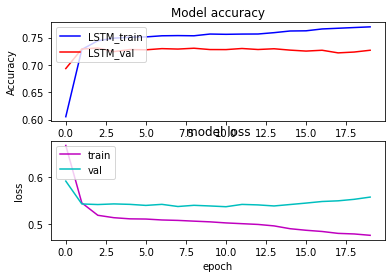

In [135]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(history.history['accuracy'], c= 'b')
ax1.plot(history.history['val_accuracy'], c='r')
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

ax2.plot(history.history['loss'], c='m')
ax2.plot(history.history['val_loss'], c='c')
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. 

**Let if**

prediction score>0.5--POSITIVE sentiment(1)

prediction score<0.5--NEGATIVE sentiment(0)

In [136]:
def sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(X_test, verbose=1, batch_size=1000)
y_pred = [sentiment(score) for score in scores]

13/13 [==============================] - 12s 902ms/step


#### **CONFUSION MATRIX**

[[4387 1881]
 [1534 4698]]


Text(0.5, 1.0, 'Confusion Matrix')

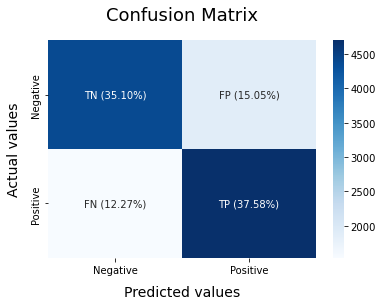

In [137]:
cm=confusion_matrix(y_test, y_pred)
print(cm)
categories = ['Negative','Positive']
group_names = ['TN','FP', 'FN','TP']
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
labels = [f'{v1} ({v2})' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot = labels, cmap = 'Blues',fmt = '',
            xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

#### **Classification Scores**

In [138]:
print(classification_report(list(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      6268
           1       0.71      0.75      0.73      6232

    accuracy                           0.73     12500
   macro avg       0.73      0.73      0.73     12500
weighted avg       0.73      0.73      0.73     12500



#### **ROC CURVE**

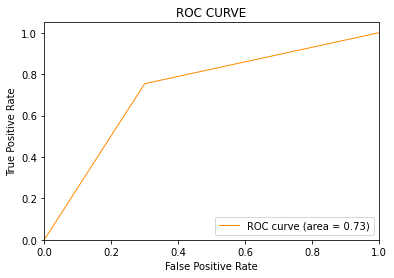

In [139]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

The model has an accuracy around 73% which is pretty okay.